# Convex Optimization Project
## Support Vector Machines solvers

Given $m$ data points $x_i \in \mathbb{R}^n$ with labels $y_i \in \{-1,1\}$, write a function to solve the classification problem

$$ \begin{array}l
\mathrm{minimize} & \frac12 {||w||}_2^2 + C \mathbf{1}^Tz \\
\mathrm{subject\ to} & y_i(w^Tx_i) \geq 1 - z_i, \quad \forall i \in \{1,\ldots,m\} \\
& z \succcurlyeq 0
\end{array} $$

in the variables $w \in \mathbb{R}^n$, $z \in \mathbb{R}^m$, and its dual (warning: this problem is a bit different from the one in exercise 1).

Solving this problem trains a classifier vector $w$ such that, up to some errors

$$ \begin{array}l
w^Tx_i > 0 & \mathrm{when}\ y_i = 1 \\
w^Tx_i < 0 & \mathrm{when}\ y_i = -1.
\end{array} $$

This classifier can then be used to classify new points $x$ as positives or negatives by simply computing the scalar product $w^Tx$.

In [8]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


- Use the barrier method to solve both primal and dual problems.

In [3]:
def newton(f, gradient_and_hessian, ɛ, x0, α=0.45, β=0.8):
    """ Newton descent method.
    @param f is the function to minimize
    @param gradient_and_hessian is a function that returns the gradient and the hessian at x
    @param ɛ is the required absolute precision
    @param x0 is a strictly feasible point, i.e., f(x0) < +inf
    @param α is a parameter for the backtracking line search
    @param β is a parameter for the backtracking line search
    @return an array of values
    """    
    x = x0
    values = [[copy(x), f(x)]]
    while True:
        # Direction computation.
        gradient, hessian = gradient_and_hessian(x)
        hessian_inv = inv(H)
        dx = -hessian_inv.dot(gradient)
        
        # Stopping criterion.
        λsquare = gradient.dot(-dx)
        if λsquare/2 <= ɛ:
            break
        
        # Backtracking line search.
        t = 1.0
        f0 = f(x)
        Δ = -λsquare
        while f(x + t*dx) > f0 + α*t*Δ:
            t *= β
        
        # Update.
        x += t*dx
        values.append([copy(x), f(x)])
    
    return array(values)

In [6]:
def barrier_method(objective, objective_gh, m, constraints, constraints_gh, ɛ, x0, t0=1.0, μ=10.0, *newton_params):
    """ Solve the SVM classifier problem.
    @param objective is the function to minimize
    @param objective_gh is a function which returns the gradient and the hessian of the objective
    @param m is the number of (inequality) constraints
    @param constraints is a function which returns the array of the f_i(x) where f_i(x) <= 0
    @param constraints_gh is a function which returns the array of gradients and hessians of the -log(-fi(x))
    @param x0 is a strictly feasible point, i.e., objective(x0) < +inf and constraints(x0) < 0
    @param t0 is a barrier parameter
    @param μ is a barrier parameter
    @param *newton_params are the additional newton method parameters
    @return an array of values
    """
    x = x0
    t = t0
    values = []
    
    def f(x):
        cons = constraints(x)
        if any(cons) <= 0:
            return float("inf")
        return objective(x) - sum(log(cons))/t
    def gradient_and_hessian(x):
        obj_g, obj_h = objective_gh(x)
        cons_g, cons_h = constraints_gh(x)
        return obj_g + cons_g/t, obj_h + cons_h/t
    
    while True:
        x = newton(f, gradient_and_hessian, ɛ, x, *newton_params)[-1][0]
        values.append([copy(v), objective(v)])
        # Stopping criterion.
        if m/t <= ɛ:
            break
        t *= μ
    
    return array(values)

To solve the original problem, we need to solve the following problems for different values of $t$:

$$ \begin{array}c
\mathrm{minimize} & \frac12 {||w||}_2^2 + C \mathbf{1}^Tz - \frac1t \left[ \sum_{i=1}^m \log \left( y_i(w^Tx_i) - 1 + z_i \right) + \sum_{i=1}^m \log(z_i) \right]
\end{array} $$

Now, we can reformulate the problem to:

$$ \begin{array}c
\mathrm{minimize} & \frac12{||w||}_2^2 + C\mathbf{1}^Tz - \frac1t \sum_{i=1}^{2m} \log(b_i - a_i^Tv)
\end{array} \\ \\
\mathrm{with}\quad v = (w,z) \in \mathbb{R}^{n+m}\quad b_i = \left\{ \begin{array}l -1 & \text{if}\ i \leq m \\ 0 & \text{if}\ i > m \end{array}\right. \quad a_i = \left\{\begin{array}l -(y_ix_i,e_i) & \text{if}\ i \leq m \\ (0,e_{i-m}) & \text{if}\ i > m \end{array}\right.\quad (e_i)_{1\leq i\leq m} \text{ is the canonical base of } \mathbb{R}^m
$$

$$ f(w,z) = \frac12 {||w||}_2^2 + C \mathbf{1}^Tz - \frac1t \sum_{i=1}^{2m} \log(b_i - a_i^Tv) $$

$$ \nabla_v f(v) = (w,C\mathbf{1}) + \frac1t\sum_{i=1}^{2m} \frac{a_i}{b_i - a_i^Tv} $$

$$ H_f(v) = \left( \begin{array}c
I_n & 0 \\
0 & 0 \\
\end{array} \right) + \frac1t \sum_{i=1}^{2m} \frac{a_i a_i^T}{\left( b_i - a_i^Tv \right)^2} $$

In [10]:
def svm_barrier(x, y, c):
    """ Solve the SVM classifier problem.
    @param x is an array of shape (m,n): the m points in dimension n
    @param y is an array of shape m and of values in {-1,1}: the labels
    @param c is the margin parameter
    @return (w,z) where w is the classifier vector (array of shape n) and z the margin vector (array of shape m)
    """
    m, n = x.shape
    # w = 0 and z_i = 2 is a strictly feasible point.
    v0 = concatenate((zeros(n), 2*ones(m)))
    a = concatenate((
            concatenate(((y*x.T).T, eye(m)), axis=1), 
            concatenate((zeros((m, n)), eye(m)), axis=1)), 
            axis=0)
    b = concatenate(-ones(m), zeros(m))
    
    scalars = array([a[i].reshape(n,1).dot(a[i].reshape(1,n)) for i in range(m)])
    def objective(v):
        w, z = x[:n], x[n:]
        return sum(w**2)/2 + c*sum(z)
    def objective_gh(v):
        w, z = x[:n], x[n:]
        gradient = concatenate(w, c*ones(m))
        hessian = concatenate((
            concatenate((eye(n), zeros((m, m))), axis=1),
            zeros((m, n+m)),
        ), axis=0)
        return gradient, hessian
    def constraints(v):
        return a.dot(v) - b
    def constraints_gh(v):
        gradient = sum((a.T / div).T, axis=0)/t
        hessian = sum((scalars.T / (div**2)).T, axis=0)/t
        return gradient, hessian
    
    ɛ = 1e-10
    values = barrier_method(objective, objective_gh, m, constraints, constraints_gh, ɛ, v0)
    v = values[-1][0]
    return v[:n], v[n:]

- Test your code on random clouds of points (e.g. generate two classes of data points by picking two bivariate Gaussian samples with different moments).

In [ ]:
def data_points(n):
    """ Generates a dataset composed of two bivariate gaussian samples with different means.
    @param n is the number of points in each class
    @return """
    σ = 
    μ1 = 
    μ2 = 

- Try various values of $C > 0$ and measure out-of-sample performance (i.e. classification errors on points the algorithm has not seen).

- Plot duality gap versus iteration number as well as a separation example in 2D (you may add a constant coefficient to the data points $x$ to allow classifiers that do not go through the origin).

(Optional) Use CVX (MATLAB or OCTAVE) or CVXOPT (python), as well as LIBSVM and/or LIBLINEAR to check your results and compare performance.

(Optional) Use the coordinate descent method to solve the dual. Plot duality gap versus iteration number and compare performance with the barrier method for various problem sizes (vary the number of samples and record to total CPU time required by each code to reduce the gap by a factor ${10}^{-3}$).

(Optional) Use the logarithmic barrier code you wrote in HW1 to solve a small random instance of the primal problem using the ACCPM algorithm. Plot an upper bound on the distance to optimality in semilog scale and try various constraint dropping strategies. Compare convergence with the two other methods.

# Better Version

# Project: Convex Optimization

In [9]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## SVM Classifier Problem

For $x_1,  x_2, \ldots, x_m \in \mathbb{R}^n$, $y_1,\ldots,y_m \in \mathbb{R}$, we consider the following minimization problem:
\begin{equation*}
\begin{aligned}
& \underset{w, z}{\text{minimize}}
& & \frac12 \|w\|_2^2 + C \mathbf{1}^Tz \\
& \text{subject to}
& & y_i(w^Tx_i) \ge 1 - z_i, \; i = 1, \ldots, m \\
& & & z \ge 0
\end{aligned}
\end{equation*}

If we compute the dual, we get the following minimization problem:
\begin{equation*}
\begin{aligned}
& \underset{\alpha}{\text{minimize}}
& & \frac12 \alpha^T \mathbf{diag}(y)XX^T\textbf{diag}(y)\alpha - \mathbf{1}^T\alpha \\
& \text{subject to}
& & 0 \le \alpha \le C
\end{aligned}
\end{equation*}

where we can recover the primal solution: $w= \sum_{i=1}^m \alpha_i y_i x_i$

Thus, we use the barrier method to solve both primal and duals:
\begin{equation*}
\begin{aligned}
& \underset{\alpha}{\text{minimize}}
& & \frac12 \alpha^T \mathbf{diag}(y)XX^T\textbf{diag}(y)\alpha - \mathbf{1}^T\alpha - \frac1t \sum_{i=1}^m (\log(\alpha_i) + \log(C - \alpha_i))
\end{aligned}
\end{equation*}

We first compute the formula for the gradient and the hessian matrix.
We first set $H = \mathbf{diag}(y)XX^T\textbf{diag}(y)$.
Then, we get:
$$\nabla f = H \alpha - \mathbf{1} + \frac1t \sum_{i=1}^m (-\frac1{\alpha_i} + \frac1{C-\alpha_i})e_i\\
\nabla^2 f = H + \frac1t \textbf{diag}(\frac1{\alpha_i^2} + \frac1{(C-\alpha_i)^2})
$$

In [10]:
def newton_svm(H, C, epsilon, alpha, beta, t=1., x_start=None, display=True, optimal_value=None):
    n, _ = H.shape
    inv_t = 1 / t
    
    # We arbitrarily choose C/2 as first position, if no x_start is supplied.
    # Otherwise, we assume that this first x is strictly feasible.
    if x_start is None:
        x = np.ones(n) * C / 2
    else:
        x = x_start
        
    errs = []
    neg_ones = -np.ones(n)
    inds = np.arange(0, n)
    Hx = H.dot(x)
    fx = 0.5 * x.dot(Hx) + neg_ones.dot(x) - inv_t * np.sum(np.log(x) + np.log(C - x))

    error = False
    while True:
        # We compute the gradient and the hessian at current point x.
        gradient = Hx + neg_ones + (1 / (C - x) - 1 / x) * inv_t
#         hessian = np.copy(H)
        modif = inv_t * (1 / (x * x) + 1 / (C - x) ** 2)
        H[inds, inds] += modif
        direction = -linalg.inv(H).dot(gradient)
        decrement = -gradient.T.dot(direction)
        H[inds, inds] -= modif
        
        step_size = 1
        prev_fx = np.nan
        # We perform an alpha beta line search in the direction given by Newton's method.
        while True:
            new_x = x + step_size * direction
            new_Hx = H.dot(new_x)
            new_fx = 0.5 * new_x.dot(new_Hx) + neg_ones.dot(new_x) - inv_t * np.sum(np.log(new_x) + np.log(C - new_x))
            
            # If new_fx is 'nan', the following equality returns False.
            # Thus, we continue to reduce the step size at least until new_x becomes feasible.
            if new_fx <= fx - decrement * step_size * alpha or prev_fx < new_fx:
                break

            step_size *= beta
            prev_fx = new_fx
            
        x = new_x
        fx = new_fx
        Hx = new_Hx
        
        # We use the Newton's decrement as an approximation of the error, if no optimal value is given to the function.
        err = decrement / 2 if optimal_value is None else fx - optimal_value
        errs.append(err)
        
        if err < epsilon:
            break
    
    if errs[-1] <= 0.:
        errs[-1] = epsilon

    if display:
        semilogy()
        plot(arange(1, len(errs) + 1), errs)
        show()
    return x, fx


def svm(X, y, C, precision=None, alpha=0.5, beta=0.5, gamma=10, x_start=None, show_step_details=False, t=1., show_steps=False):
    m, n = X.shape
    X = np.concatenate((X, np.ones((m, 1))), axis=1)
    Xy = X * y[:, None]
    H = Xy.dot(Xy.T)
    
    x = x_start
    if precision is None:
        precision = 1e-13 * C
    elif precision < 1e-13 * C:
        print("Modified precision to %.0e to guarantee convergence." % (1e-13 * C))
        precision = 1e-13 * C
    
    epsilon = precision
    step = 0
    central_path = []
    
    while 2*m / t > epsilon:
        if show_steps:
            print("Step", step)
        step += 1
        x, f_x = newton_svm(H, C, epsilon, alpha, beta, t=t, x_start=x, display=show_step_details)
        t *= gamma
        central_path.append(x)
    
    w = X.T.dot(y * x)
    
    return w, x, np.array(central_path)

# TODO
- With a kernel
- Support vectors
- Weights of support vectors
- Classification function

In [11]:
def generate(mu1, sigma1, mu2, sigma2, N1, N2):
    mu1 = np.array(mu1)
    mu2 = np.array(mu2)
    sigma1 = np.array(sigma1)
    sigma2 = np.array(sigma2)
    
    mu = (mu1 + mu2) / 2.
    mu1 = mu1 - mu
    mu2 = mu2 - mu
    X_train = np.concatenate([np.random.multivariate_normal(mu1, sigma1, N1), np.random.multivariate_normal(mu2, sigma2, N1)], axis=0)
    y_train = np.concatenate([-np.ones(N1), np.ones(N1)], axis=0)
    X_test = np.concatenate([np.random.multivariate_normal(mu1, sigma1, N2), np.random.multivariate_normal(mu2, sigma2, N2)], axis=0)
    y_test = np.concatenate([-np.ones(N2), np.ones(N2)], axis=0)
    return ((X_train, y_train), (X_test, y_test))

def plot_dataset(dataset, letter="", printing=True):
    train_x, train_y = dataset[0]
    plt.scatter(train_x[train_y == -1.][:, 0], train_x[train_y == -1.][:, 1], color='r')
    plt.scatter(train_x[train_y == 1.][:, 0], train_x[train_y == 1.][:, 1], color='b')
    plt.title("Dataset " + letter)
    xlim(np.min(dataset[0][0][:, 0]), np.max(dataset[0][0][:, 0]))
    ylim(np.min(dataset[0][0][:, 1]), np.max(dataset[0][0][:, 1]))
    
    if printing:
        plt.show()

def plot_point(point1, point2):
    plt.plot([point1[0], point2[0]], [point1[1], point2[1]], color='black')

def display_results(dataset, w, letter=""):
    plot_dataset(dataset, letter, False)
    
    # We plot the orthogonal line to vector w
    orth = np.array([-w[1], w[0]])
    offset = w[-1]
    w = w[:-1]
    unit_dir = w / np.linalg.norm(w) ** 2
    point0 = unit_dir * (- offset)
    point1 = point0 + 100*orth
    point2 = point0 - 100*orth
    plot_point(point1, point2)
    point0 = unit_dir * (1 - offset)
    point1 = point0 + 100*orth
    point2 = point0 - 100*orth
    plot_point(point1, point2)
    point0 = unit_dir * (-1 - offset)
    point1 = point0 + 100*orth
    point2 = point0 - 100*orth
    plot_point(point1, point2)
    plt.show()
    x_test, y_test = dataset[1]
    x_train, y_train = dataset[0]
    test_accuracy = 100 * np.mean((x_test.dot(w) + offset > 0) * 2 - 1 == y_test)
    train_accuracy = 100 * np.mean((x_train.dot(w) + offset > 0) * 2 - 1 == y_train)
    print("Train Accuracy: %.2f %%\n Test Accuracy: %.2f %%" % (train_accuracy, test_accuracy))

## Unit tests

[ 1. -1.  0.]
[ 1.  1.]
[[ 1.53384082  1.53384082]
 [ 1.08127136  1.08127136]
 [ 1.00880056  1.00880056]
 [ 1.00088799  1.00088799]
 [ 1.00008888  1.00008888]
 [ 1.00000889  1.00000889]
 [ 1.00000089  1.00000089]
 [ 1.00000009  1.00000009]
 [ 1.00000005  1.00000005]
 [ 1.          1.        ]
 [ 1.          1.        ]
 [ 1.          1.        ]
 [ 1.          1.        ]]


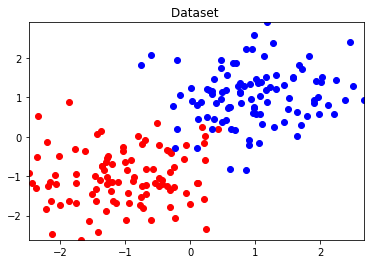

Modified precision to 1e-10 to guarantee convergence.
Step 0


/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log


Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12


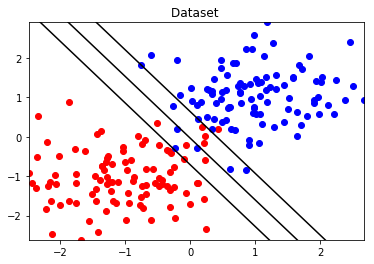

Train Accuracy: 96.50 %
 Test Accuracy: 100.00 %


In [12]:
X = array([[1, 0],
           [0, 1]])
y = array([1, -1])
w, α, c = svm(X, y, 10)

print(w)
print(α)
print(c)

sigma = 0.5
cov = np.eye(2) * sigma
dataset = generate([-1, -1], cov, [1, 1], cov, 100, 100)
plot_dataset(dataset)
w, alpha, central_path = svm(dataset[0][0], dataset[0][1], 1e3, show_steps=True, precision=1e-14)
display_results(dataset, w)

# Tests

In [17]:
def read_file(filename):
    xs = []
    ys = []
    with open(filename, 'r') as src:
        for line in src:
            x1, x2, y = line.split()
            x1 = float(x1)
            x2 = float(x2)
            y = float(y)
            xs.append([x1, x2])
            ys.append(y)
    return np.array(xs), np.array(ys) * 2 - 1

def import_dataset(letter):
    train = "%s/classification%s.train" % ("classification_data", letter)
    test = "%s/classification%s.test" % ("classification_data", letter )
    
    return read_file(train), read_file(test)

def plot_results(letter, C=1):
    dataset = import_dataset(letter)
    train = dataset[0]
    results = dict()
    
    results["svm"] = svm(dataset[0][0], dataset[0][1], C)
    
    for method in ["svm"]:
        display_results(dataset, results[method][0], letter+" with "+method)    

/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log


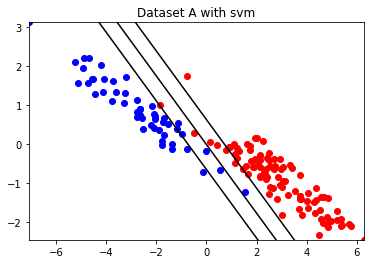

Train Accuracy: 98.00 %
 Test Accuracy: 98.20 %


In [18]:
plot_results('A', C=1)

/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log


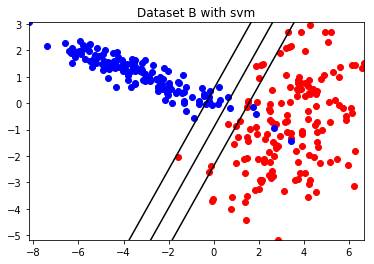

Train Accuracy: 98.00 %
 Test Accuracy: 95.85 %


In [19]:
plot_results('B')

/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log


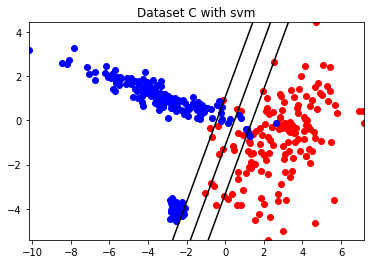

Train Accuracy: 96.00 %
 Test Accuracy: 97.77 %


In [20]:
plot_results('C')

In [21]:
def plot_result_function(letter, classifier, method="??"):
    plot_dataset(dataset, letter+' with '+method, printing=False)
    X, Y = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
    points = np.stack([X, Y], axis=2)
    qda_value = np.array([[classifier(x) for x in a] for a in points])
    plt.contour(X, Y, qda_value, [0])
    x_test, y_test = dataset[1]
    x_train, y_train = dataset[0]
    train_labels = (np.array([classifier(x) for x in x_train]) > 0.) * 2 - 1
    train_accuracy = np.mean(train_labels == y_train) * 100
    test_labels = (np.array([classifier(x) for x in x_test]) > 0.) * 2 - 1
    test_accuracy = np.mean(test_labels == y_test) * 100
    plt.show()
    print("Train Accuracy: %.2f %%\n Test Accuracy: %.2f %%" % (train_accuracy, test_accuracy))

# Comparison with LibSVM and LibLinear

In [25]:
from sklearn.svm import SVC, LinearSVC

datasetA = import_dataset("A")
datasetA = ((datasetA[0][0] + 1, datasetA[0][1]), (datasetA[1][0] + 1, datasetA[1][1]))
X, y = datasetA[0]

C = 1
%time w, α, _ = svm(X, y, C)

clf = LinearSVC(C=C, loss='hinge')
# clf = SVC(C=C, kernel='linear')
%time clf.fit(X, y)
print(np.mean(clf.predict(datasetA[1][0]) == datasetA[1][1]))

print(clf.intercept_)
print(w)
print(clf.get_params(deep=False))
m = len(X)
# print(α)
print(C / m)
print(np.sum(α > 0.9*(C / m)))
print(np.max(α))

CPU times: user 440 ms, sys: 12 ms, total: 452 ms
Wall time: 143 ms
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 669 µs
0.982666666667
[ 1.9306341]
[-1.05593335 -0.97963069  1.93072525]
{'C': 1, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}
0.006666666666666667
17
1.0


/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log


In [23]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, [-1, 0, 1], **params)
    return out

17


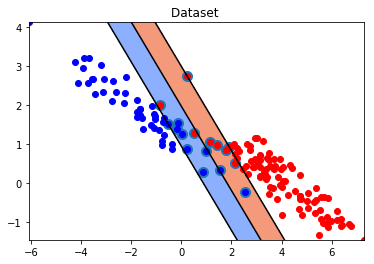

Train Accuracy: 97.33 %
 Test Accuracy: 98.27 %


Text(0.5,1,'SVC')

In [24]:
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)
ax = plt.axes()
plot_contours(ax, clf, xx, yy,
              cmap=plt.cm.coolwarm_r)
# ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
# ax.set_xlim(xx.min(), xx.max())
# ax.set_ylim(yy.min(), yy.max())
# ax.set_xticks(())
# ax.set_yticks(())

# ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
#            linewidth=1)
my_support_vectors = X[np.logical_and(α > 1e-6, α <= C-0*1e-6)]
print(len(my_support_vectors))
ax.scatter(my_support_vectors[:, 0], my_support_vectors[:, 1], s=100,
           linewidth=1)
display_results(datasetA, w)
ax.set_title("SVC")